In [99]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.3)

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Machine Learning Online Class Exercise 6 | Support Vector Machines

## Support vector machines (SVM)
Take the cost function for the logistic regression:
$$J(\vec{\theta})=\frac{1}{m}\sum_{\alpha=1}^m \left[-y_{\alpha}\log(h(z_{\alpha}))-(1-y_{\alpha})\log(1-h(z_{\alpha}))\right]+\frac{\lambda}{2m}\sum_{i=1}^n\theta_i^2,\ \ \ z_{\alpha}=\vec{x}_{\alpha}\cdot\vec{\theta}$$
where
$$h(z)=\frac{1}{1+e^{-z}}.$$
We see that $J$ is composed of two parts, one which is present when $y=1$ and the other one present when $y=0$.<br><br>
We are going to propose a new cost function and replace the functions for similar but simplified fuctions (called *hinge loss* functions):
\begin{align}
-\log(h(z))\rightarrow&\max(0,1-z)\\
-\log(1-h(z))\rightarrow&\max(0,z+1),
\end{align}
and remove the prefactor $1/m$ and replace the regularization parameter $\lambda$ for a new parameter $C$ that multiplies the first part of the cost function instead of the second one
\begin{align}
J(\vec{\theta})&=C\sum_{\alpha=1}^m \left[y_{\alpha}\max(0,1-z_{\alpha})+(1-y_{\alpha})\max(0,z_{\alpha}+1)\right]+\frac{1}{2}\sum_{i=1}^n\theta_i^2,\ \ \ z_{\alpha}=\vec{x}_{\alpha}\cdot\vec{\theta}\\
&=J_1+J_2,
\end{align}
where $J_1$ is called the error term and $J_2$ the regularizer.

In [16]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

x = list(np.arange(-3,3,0.1))
y1 = [-np.log(sigmoid(i)) for i in x]
y0 = [-np.log(1-sigmoid(i)) for i in x]
r0 = [max(0,i+1) for i in x]
r1 = [max(0,1-i) for i in x]
lsig_df = pd.DataFrame({'x':x,'y1':y1,'r1':r1,'y0':y0,'r0':r0})

Text(0, 0.5, '$f(z)$')

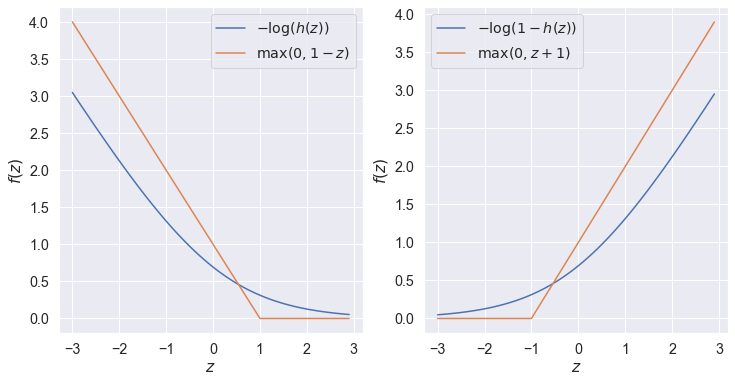

In [17]:
fig0, ax = plt.subplots(1,2,figsize=(12, 6))
sns.lineplot(data=lsig_df, ax=ax[0], x='x', y='y1',label=r'$-\log(h(z))$')
sns.lineplot(data=lsig_df, ax=ax[0], x='x', y='r1',label=r'$\max(0,1-z)$')
sns.lineplot(data=lsig_df, ax=ax[1], x='x', y='y0',label=r'$-\log(1-h(z))$')
sns.lineplot(data=lsig_df, ax=ax[1], x='x', y='r0',label=r'$\max(0,z+1)$')
ax[0].set_xlabel(r'$z$')
ax[1].set_xlabel(r'$z$')
ax[0].set_ylabel(r'$f(z)$')
ax[1].set_ylabel(r'$f(z)$')

Now we want to train the SVM for the classification problem by finding the $\theta$ that minimize the forst part of $J$ ($J_1$), and we can see that

| J1 | z | y |
| :-: | :-: | :-: |
| 0 | >1 | 1 |
| >0 | <1 | 1 |
| 0 | <-1 | 0 |
| >0 | >-1 | 0 |

which means that $J$ is minimized when $z\geq1$ and $y=1$ or when $z\leq-1$ and $y=0$. <br>
As $z=\vec{x}\cdot\vec{\theta}=|\theta||x|\cos\phi$, where $\phi$ is the angle between the parameter vector and the feature vector. Therefore, $z$ is maximized when these vectors are parallel or minimized when they are aniparallel, which leads to a minimum value for $J_1$. As for $J_2$, it is minimized when the squared norm of the parameter vector (minus the bias term $\theta_0$) is minimized.<br >
<img src="boundary_sel.png" width=400/>
The vector $\vec{\theta}$ can be regarded as the normal vector to an hyperplane. By minimizing both parts of $J$ the hyperplane will locate in a position where the data points are as parallel (or antiparallel) to the parameter vector as possible (by maximizing the absolute value of $z$), while minimizing the norm of $\vec{\theta}$. These conditions create a hyperplane that divides the two classes, corresponding to $y=0$ and $y=1$, maintaining its perpendicular distance to all of the points as large as possible.

## Kernel method
The optimization of an SVM problem produces a hyperplane that separates the samples into classes. In many cases there is no plane that separates all the samples into their own classes in the space in which the samples reside, however, a transformation $\phi(\cdot)$ can be applied to the data that takes it to a Hilbert space $\mathcal{H}$ in which a separation hyperplane can be found. This new space has to be such that the inner product is represented as a symmetric, non-negative definite *kernel*
$$k(x_{\alpha},x_{\beta})=\left<\phi(x_{\alpha}),\phi(x_{\beta})\right>_{\mathcal{H}}.$$
We define the similarity function
$$f_{\alpha}(x)=k(x_{\alpha},x)$$
and use the $f_{\alpha}$ as the new features of the problem, so that now we have
$$z_{\alpha}=\vec{f}(x_{\alpha})\cdot\vec{\theta},$$
where
$$\vec{f}(x)=\left(f_0,f_1(x),f_2(x),\cdots,f_m(x)\right),\ \ \ f_0=1,$$
and we have a number of parameters $\theta$ equal to the number of sample points $m$ plus one. That is
$$J(\vec{\theta})=C\sum_{\alpha=1}^m \left[y_{\alpha}\max(0,1-z_{\alpha})+(1-y_{\alpha})\max(0,z_{\alpha}+1)\right]+\frac{1}{2}\vec{\theta}'^T M\ \vec{\theta}',$$
where $M$ is a $m\times m$ matrix used to improve the numerical performance of the optimization, and $\vec{\theta}'$ is the parameter vector without $\theta_0$.
As the hinge loss functions are not differentiable at $z=1$ (or $z=-1$), instead of the gradient the *subgradient* as to be used at this points. For example, for the function $\max(0,1-z)$ the subgradient is
$$g(z)=\left\{\begin{array}{lc}
-1 & z<1\\
[-1,0] & z=1\\
0 & z > 1
\end{array}\right. .$$
The definition of subgradient is<br >
<p style="text-align: center;"> 
A vector $\vec{g}\in\mathbb{R}^d$ is a subgradient of a function $f:\mathbb{R}^d\rightarrow\mathbb{R}$ at the point $\vec{x}_0$ if for all points $\vec{x}$ the following holds
    $$f(x)\geq f(\vec{x}_0)+\vec{g}^T(\vec{x}-\vec{x}_0).$$
</p> <br>
A common similarity function is the gaussian (also called radial basis function) kernel 
$$f_{\alpha}(x)=\exp\left({-\frac{|x_{\alpha}-x|^2}{2\sigma^2}}\right),$$
and the choice $f_{\alpha}(x)=x$, called the *linear* kernel, gives us the basic SVM.<br >
Finally, for multiple classification problems, the one-vs-all method can be used.

When to choose SVM over logistic regression? <br>
Usually when the dimension of the feature space $n$ is not very large <1000 and the number of data points $m$ is around 10-10000.

## Dual support vector machine
By noting that
$$y\max(0,1-z)+(1-y)\max(0,1+z)=\max(0,1-(2y-1)z)$$
we can write our unconstrained minimization problem as
$$\min_{\theta',\theta_0}C\sum_{\alpha=1}^m\max(0,1-(2y_{\alpha}-1)z_{\alpha})+\frac{1}{2}|\theta'|^2,$$
where $\theta'$ does not include $\theta_0$ and $z_{\alpha}=\vec{x}_{\alpha}\cdot\vec{\theta}'+\theta_0$.<br>
On the other hand, an unconstrained problem of the type
$$\min_{t}\max(0,1-t)$$
is equivalent to the constrained problem
\begin{align}
&\min_{t,\xi}\xi\\
\mbox{Subject to }& \xi\geq 0,\ \ \xi\geq 1-t,
\end{align}
and our constrained minimization problem is
\begin{align}
\min_{\theta',\theta_0,\xi}&\ C\sum_{\alpha=1}^m\xi_{\alpha}+\frac{1}{2}|\theta'|^2,\\
\mbox{Subject to }& \xi_{\alpha}\geq0,\ \ \xi_{\alpha}\geq1-(2y_{\alpha}-1)z_{\alpha}.
\end{align}
We may now use the method of Lagrange multipliers to solve this constrained problem. The Lagrangian is
\begin{align}
\mathcal{L}(\theta',\theta_0,\xi,\mu,\gamma)&=C\sum_{\alpha=1}^m\xi_{\alpha}+\frac{1}{2}|\theta'|^2-\sum_{\alpha=1}^m\mu_{\alpha}((2y_{\alpha}-1)z_{\alpha}-1+\xi_{\alpha})-\sum_{\alpha=1}^m\gamma_{\alpha}\xi_{\alpha}.
\end{align}
By differentiating the Lagrangian we obtain
\begin{align}
\frac{\partial\mathcal{L}}{\partial\vec{\theta}'}&=\vec{\theta}'-\sum_{\alpha=1}^m\mu_{\alpha}(2y_{\alpha}-1)\vec{x}_{\alpha}=0\\
\frac{\partial\mathcal{L}}{\partial\theta_0}&=-\sum_{\alpha=1}^m\mu_{\alpha}(2y_{\alpha}-1)=0\\
\frac{\partial\mathcal{L}}{\partial\xi_{\alpha}}&=C-\mu_{\alpha}-\gamma_{\alpha}=0.
\end{align}
For the first equation we obtain
$$\vec{\theta}'=\sum_{\alpha=1}^m\mu_{\alpha}(2y_{\alpha}-1)\vec{x}_{\alpha}.$$
This equation depends on the samples $(\vec{x}_{\alpha},y_{\alpha})$, and the importance of each sample in the determination of the parameters is given by its coeficient $\mu_{\alpha}$. Those samples for which $\mu_{\alpha}>0$ are called **support vectors**, and this is the reason why they are called *support vector machines*.<br>
By inserting the equations in the Lagrangian we obtain the constrained negative dual minimization problem
\begin{align}
\min_{\mu}\frac{1}{2}\sum_{\alpha=1}^m\sum_{\beta=1}^m\mu_{\alpha}\mu_{\beta}(2y_{\alpha}-1)(2y_{\beta}-1)(\vec{x}_{\alpha}\cdot\vec{x}_{\beta})-\sum_{\alpha=1}^m\mu_{\alpha}\\
\mbox{Subject to }\sum_{\alpha=1}^m\mu_{\alpha}(2y_{\alpha}-1)=0,\ \ 0\leq\mu_{\alpha}\leq C\mbox{ for all }\alpha=1,\dots,m.
\end{align}

## =============== Part 1: Loading and Visualizing Data ================

In [18]:
data = loadmat("ex6data1.mat")
X = data['X']
y = data['y']
data_tot = np.concatenate((X,y),axis=1)
X.shape, y.shape

((51, 2), (51, 1))

In [19]:
data_df = pd.DataFrame(data_tot, columns=['x1','x2','y'])
display(data_df.head())

,x1,x2,y
0,1.9643,4.5957,1.0
1,2.2753,3.8589,1.0
2,2.9781,4.5651,1.0
3,2.9320,3.5519,1.0
4,3.5772,2.8560,1.0


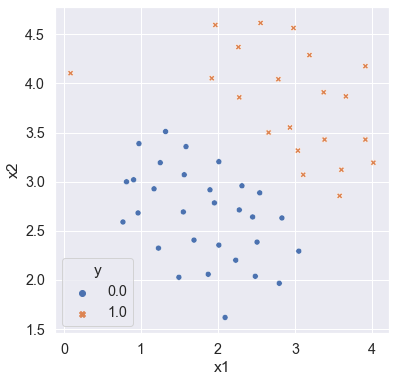

In [20]:
fig0, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=data_df, ax=ax, x='x1', y='x2', hue='y', style='y')

## ==================== Part 2: Training Linear SVM ====================

In [21]:
#We'll use sklearn library implementation of SVMs

In [22]:
#separate data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40, 2), (11, 2), (40, 1), (11, 1))

In [23]:
#kernel is the kernel to use
#C is the error term coefficient
#tol is the stopping criterion for iterations
svclassifierA = SVC(kernel='linear', C=1.0, tol=1.e-3)

#Train the classifier
svclassifierA.fit(X_train, y_train)
thetaA = svclassifierA.coef_[0]
theta0A = svclassifierA.intercept_[0]
thetaA, theta0A

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(array([0.98976377, 1.78750733]), -8.144098993417224)

In [24]:
a = -thetaA[0] / thetaA[1]
xx = np.linspace(0,4)
xx = xx.reshape(xx.shape[0],1)
yy = a * xx - theta0A / thetaA[1]
lin_tot = np.concatenate((xx,yy),axis=1)
lin_dfA = pd.DataFrame(lin_tot, columns=['x1','x2'])
#display(lin_dfA.head())

In [25]:
svclassifierB = SVC(kernel='linear', C=100.0, tol=1.e-3)

#Train the classifier
svclassifierB.fit(X_train, y_train)
thetaB = svclassifierB.coef_[0]
theta0B = svclassifierB.intercept_[0]
thetaB, theta0B

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(array([ 4.68152053, 13.08948621]), -53.13062014980603)

In [26]:
a = -thetaB[0] / thetaB[1]
xx = np.linspace(0,4)
xx = xx.reshape(xx.shape[0],1)
yy = a * xx - theta0B / thetaB[1]
lin_tot = np.concatenate((xx,yy),axis=1)
lin_dfB = pd.DataFrame(lin_tot, columns=['x1','x2'])

[Text(0.5, 1.0, 'C=100.0')]

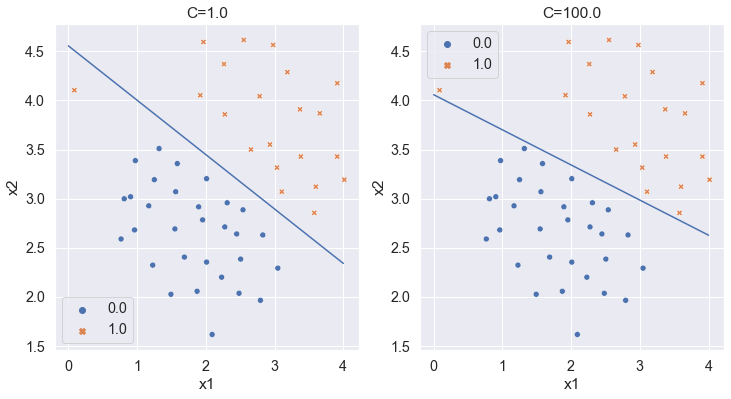

In [27]:
fig1, ax = plt.subplots(1,2,figsize=(12,6))
sns.scatterplot(data=data_df, ax=ax[0], x='x1', y='x2', hue='y', style='y')
sns.lineplot(data=lin_dfA, ax=ax[0], x='x1', y='x2').set(title='C=1.0')
sns.scatterplot(data=data_df, ax=ax[1], x='x1', y='x2', hue='y', style='y')
sns.lineplot(data=lin_dfB, ax=ax[1], x='x1', y='x2').set(title='C=100.0')

## =============== Part 4: Visualizing Dataset 2 ================

In [29]:
data2 = loadmat("ex6data2.mat")
X2 = data2['X']
y2 = data2['y']
data2_tot = np.concatenate((X2,y2),axis=1)
X2.shape, y2.shape

((863, 2), (863, 1))

In [30]:
data2_df = pd.DataFrame(data2_tot, columns=['x1','x2','y'])
display(data2_df.head())

,x1,x2,y
0,0.107143,0.603070,1.0
1,0.093318,0.649854,1.0
2,0.097926,0.705409,1.0
3,0.155530,0.784357,1.0
4,0.210829,0.866228,1.0


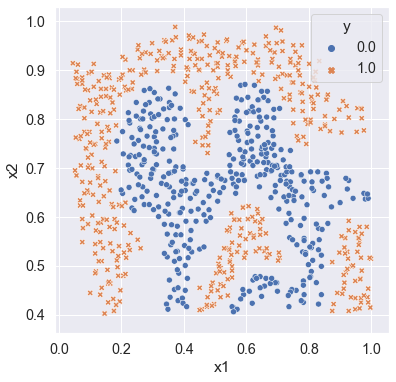

In [31]:
fig2, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=data2_df, ax=ax, x='x1', y='x2', hue='y', style='y')

## ========== Part 5: Training SVM with RBF Kernel (Dataset 2) ==========

In [97]:
#separate data into train and test sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.20)
train2_tot = np.concatenate((X2_train,y2_train),axis=1)
test2_tot = np.concatenate((X2_test,y2_test),axis=1)
train2_df = pd.DataFrame(train2_tot, columns=['x1','x2','y'])
test2_df = pd.DataFrame(test2_tot, columns=['x1','x2','y'])
X2_train.shape, X2_test.shape, y2_train.shape, y2_test.shape

((690, 2), (173, 2), (690, 1), (173, 1))

In [125]:
#kernel is the kernel to use
#C is the error term coefficient
#gamma is the additional parameter (1/2var for rbf?)
#tol is the stopping criterion for iterations
modelA = SVC(kernel='rbf', C=20.0, gamma=10.0, tol=1.e-3)

#Train the classifier
modelA.fit(X2_train, y2_train)
supportA = modelA.support_vectors_
dualcA = modelA.dual_coef_.T
supportA_df = pd.DataFrame(wsuppA, columns=['x1', 'x2'])
supportA_df['y'] = supportA_df['x1'].apply(lambda l: 1 if l>0 else 0)
#supportA.shape, dualcA.shape

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [126]:
pred = []
for x in X2_test:
    pred.append(modelA.predict([[x[0], x[1]]])[0])
accuracy_score(pred,y2_test.flatten())

0.9826589595375722

In [127]:
x1vals = [x for x in np.arange(0,1,0.02)]
x2vals = [x for x in np.arange(0.4,1,0.02)]
coefgridA = np.array([[modelA.predict([[i, j]])[0] for i in x1vals] for j in x2vals])
coefgridA.shape

(30, 50)

<ipython-input-128-9870cee18fad>:3: UserWarning: No contour levels were found within the data range.
  ax[0].contour(coefgridA,cmap='inferno',extent=[0,1,0.4,1],levels=[0.0])


[Text(0.5, 1.0, 'support vectors')]

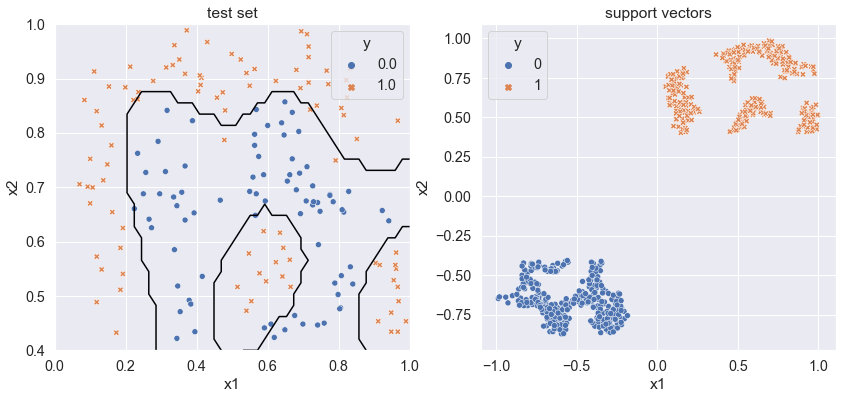

In [128]:
fig3, ax = plt.subplots(1,2,figsize=(14,6))
sns.scatterplot(data=test2_df, ax=ax[0], x='x1', y='x2', hue='y', style='y').set(title='test set')
ax[0].contour(coefgridA,cmap='inferno',extent=[0,1,0.4,1],levels=[0.0])
sns.scatterplot(data=supportA_df, ax=ax[1], x='x1', y='x2', hue='y', style='y').set(title='support vectors')

## =============== Part 6: Visualizing Dataset 3 ================